<h1>CNN model za prepoznavanje šalica</h1>
<hr/>
<h2>Iteracija Lima</h2>

<p> Set slika je 700/100, Dropot-a i Data Augmentation i regularizacija</p>
<p>dodavanje transfer learninga na odabrane iteracije: k5</p>

In [2]:
import os
import random

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout, SpatialDropout2D

import matplotlib.pyplot as plt
import numpy as np

<h4>POstavljanje sjemena za ponavljanje rezultata:</h4>

In [3]:
seed = 77
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

<p>Postavljanje direktorija sa trening i validacijskim slikama:</p>

In [4]:
# Postavi direktorije slika
train_dir = "../../Projekt_slike_128/Trening"
test_dir = "../../Projekt_slike_128/Validacija"

<h3> Funkcija za određivanje broja epoha, veličinu batcheva i generiranje podataka</h3>

In [5]:
def generate_epochs_batchs_data():
    """ određivanje i priprema podataka """
    # Odredi broj epoha i veličinu batcheva
    num_of_epochs = input("Number of epochs:")
    num_of_epochs = int(num_of_epochs)
    size_of_batch = input("Batch size:")
    size_of_batch = int(size_of_batch)
    # Generator podataka sa augmentacijom za trening
    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=50,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        fill_mode="nearest",
    )
    test_datagen = ImageDataGenerator(rescale=1.0 / 255)

    train_generator = train_datagen.flow_from_directory(
        train_dir, target_size=(128, 128), batch_size=size_of_batch, class_mode="categorical"
    )

    test_generator = test_datagen.flow_from_directory(
        test_dir, target_size=(128, 128), batch_size=size_of_batch, class_mode="categorical"
    )
    return(train_generator,test_generator, num_of_epochs, size_of_batch)

In [8]:
traintest_generators = generate_epochs_batchs_data()
train_generator = traintest_generators[0]
test_generator = traintest_generators[1]
num_of_epochs = traintest_generators[2]
size_of_batch = traintest_generators[3]

Number of epochs: 100
Batch size: 128


Found 2100 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


<h4>Funkcija za plotanje rezultata: </h4>

In [6]:
def plots_and_evaluation(history):
    """ funkcija za plotanje točnosti i gubitka  """
    # Plot trening i valuacija - točnost
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("Model accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")

    # Plot trening i validacija - gubitak
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Model loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.show()

<h5>Prikaz random primjera slika: </h5>

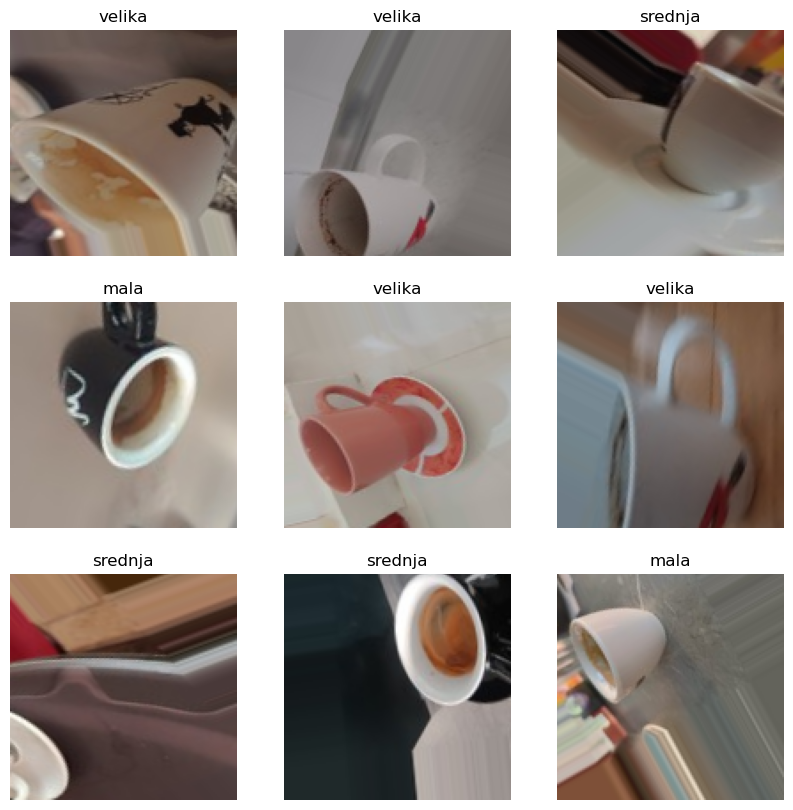

In [9]:
# Primjeri slika
def display_sample_images(generator):
    x, y = next(generator)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(x[i])
        
        if (np.argmax(y[i])==0):
            plt.title("mala")
        if (np.argmax(y[i])==1):
            plt.title("srednja")
        if (np.argmax(y[i])==2):
            plt.title("velika")
        plt.axis("off")
    plt.show()


display_sample_images(train_generator)

In [13]:
# CNN model
model = Sequential(
    [
        Conv2D(8, (3, 3), activation="relu", input_shape=(128, 128, 3)),
        MaxPooling2D((2, 2)),
        SpatialDropout2D(0.5),
        Conv2D(16, (3, 3), activation="relu", kernel_regularizer=l2(0.001)),
        MaxPooling2D((2, 2)),
        SpatialDropout2D(0.5),
        Conv2D(32, (3, 3), activation="relu",  kernel_regularizer=l2(0.001)),
        SpatialDropout2D(0.5),
        MaxPooling2D((2, 2)),
        SpatialDropout2D(0.5),
        Flatten(),
        Dense(512, activation="relu"),
        Dense(128, activation="relu"),
        Dense(3, activation="softmax"),
    ]
)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 126, 8)       224       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 63, 63, 8)         0         
 g2D)                                                            
                                                                 
 spatial_dropout2d_8 (Spati  (None, 63, 63, 8)         0         
 alDropout2D)                                                    
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 16)        1168      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 30, 30, 16)        0         
 g2D)                                                            
                                                      

In [14]:
# Kompajliranje
optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Treniranje
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=num_of_epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
)

Epoch 1/100


2024-08-25 23:31:47.649323: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/spatial_dropout2d_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


16/16 [==============================] - 40s 2s/step - loss: 1.1876 - accuracy: 0.3377 - val_loss: 1.1262 - val_accuracy: 0.3359
Epoch 2/100
16/16 [==============================] - 33s 2s/step - loss: 1.1311 - accuracy: 0.3428 - val_loss: 1.1273 - val_accuracy: 0.3242
Epoch 3/100
16/16 [==============================] - 33s 2s/step - loss: 1.1339 - accuracy: 0.3357 - val_loss: 1.1263 - val_accuracy: 0.3594
Epoch 4/100
16/16 [==============================] - 33s 2s/step - loss: 1.1259 - accuracy: 0.3474 - val_loss: 1.1241 - val_accuracy: 0.3359
Epoch 5/100
16/16 [==============================] - 33s 2s/step - loss: 1.1205 - accuracy: 0.3494 - val_loss: 1.1219 - val_accuracy: 0.3398
Epoch 6/100
16/16 [==============================] - 33s 2s/step - loss: 1.1220 - accuracy: 0.3560 - val_loss: 1.1212 - val_accuracy: 0.5273
Epoch 7/100
16/16 [==============================] - 33s 2s/step - loss: 1.1135 - accuracy: 0.3732 - val_loss: 1.1200 - val_accuracy: 0.4844
Epoch 8/100
16/16 [======

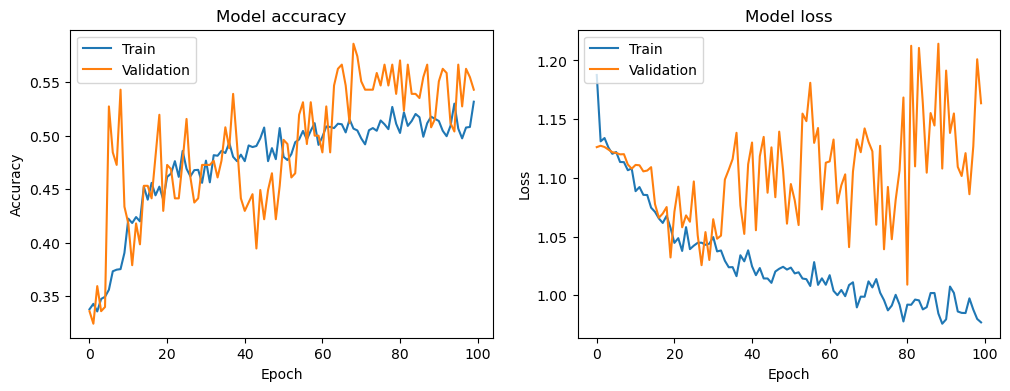

2/2 [==============================] - 1s 365ms/step - loss: 1.1524 - accuracy: 0.5469
Test accuracy: 0.546875


In [15]:
#Plotovi
plots_and_evaluation(history)
# Evaluacija modela
test_loss, test_acc = model.evaluate(
    test_generator, steps=test_generator.samples // test_generator.batch_size
)
print("Test accuracy:", test_acc)

In [16]:
# Spremanje modela
model.save('iteracija_k5.h5')

<h3>Transfer learning</h3>

In [7]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import  Model
from tensorflow.keras.layers import GlobalAveragePooling2D

In [22]:
# Učitavanje pred treniranog modela
vgg19_model = VGG19(weights='imagenet', include_top=False, input_shape=(128,128,3))

# DOdavanje slojeva
#
x = vgg19_model.output
x = GlobalAveragePooling2D()(x)  
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)  
x = Dropout(0.5)(x)  
predictions = Dense(3, activation='softmax')(x)  # Završni izlazni sloj sa 3 klase

# KOmbiniranje ResNet50 slojeva sa dodanim slojevima(x)
model = Model(inputs=vgg19_model.input, outputs=predictions)


# Odmrzivanje zadnjih 30 pred treniranih slojeva
for layer in vgg19_model.layers:
    layer.trainable = False

In [23]:
# Kompajliranje modela
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
# Pregled modela
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [25]:
traintest_generators = generate_epochs_batchs_data()
train_generator = traintest_generators[0]
test_generator = traintest_generators[1]
num_of_epochs = traintest_generators[2]
size_of_batch = traintest_generators[3]

Number of epochs: 100
Batch size: 64


Found 2100 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


In [26]:
# Treniranje u 100 epoha
history = model.fit(
    train_generator,
    
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=num_of_epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size
)

Epoch 1/100
32/32 [==============================] - 82s 2s/step - loss: 1.5807 - accuracy: 0.3826 - val_loss: 1.2796 - val_accuracy: 0.5938
Epoch 2/100
32/32 [==============================] - 77s 2s/step - loss: 1.2881 - accuracy: 0.5334 - val_loss: 1.2018 - val_accuracy: 0.5664
Epoch 3/100
32/32 [==============================] - 76s 2s/step - loss: 1.1720 - accuracy: 0.5668 - val_loss: 1.1064 - val_accuracy: 0.5938
Epoch 4/100
32/32 [==============================] - 77s 2s/step - loss: 1.0729 - accuracy: 0.6036 - val_loss: 1.0729 - val_accuracy: 0.6172
Epoch 5/100
32/32 [==============================] - 77s 2s/step - loss: 1.0309 - accuracy: 0.6267 - val_loss: 1.0917 - val_accuracy: 0.5742
Epoch 6/100
32/32 [==============================] - 77s 2s/step - loss: 0.9790 - accuracy: 0.6508 - val_loss: 1.0656 - val_accuracy: 0.6484
Epoch 7/100
32/32 [==============================] - 76s 2s/step - loss: 0.9555 - accuracy: 0.6577 - val_loss: 1.1126 - val_accuracy: 0.6211
Epoch 8/100
3

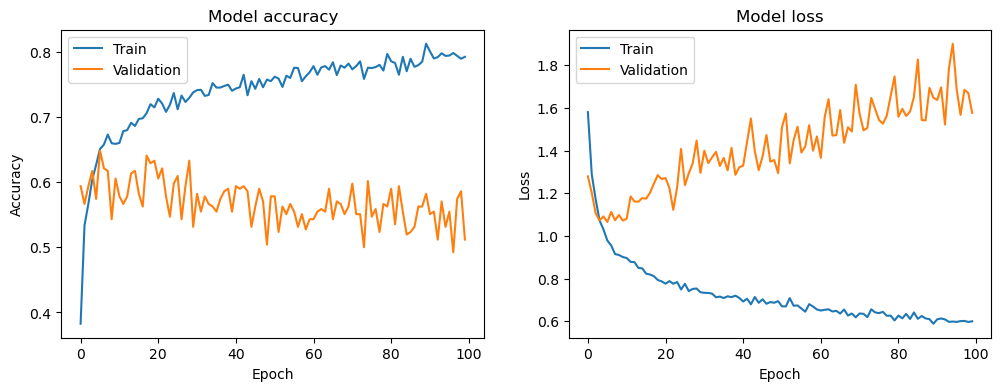

4/4 [==============================] - 6s 2s/step - loss: 1.5865 - accuracy: 0.4961
Test accuracy: 0.49609375


In [27]:
#Plotovi
plots_and_evaluation(history)
# Evaluacija modela
test_loss, test_acc = model.evaluate(
    test_generator, steps=test_generator.samples // test_generator.batch_size
)
print("Test accuracy:", test_acc)